
***
В приложенных файлах вы увидите данные по прохождению студентами тестов на образовательной платформе. Такие данные могут быть использованы для построения персонализированных ИИ-ассистентов для поддержки обучения студента. На текущем этапе сосредоточимся на начальном этапе — сборе и подготовке данных.
***
Используя библиотеку pandas (или аналоги), проанализировать как можно больше характеристик, влияющих на успеваемость студентов.
***
#### TRAIN.CSV
* row_id: (int64) ID code for the row.
* timestamp: (int64) the time in milliseconds between this user interaction and the first event completion from that user.
* user_id: (int32) ID code for the user.
* content_id: (int16) ID code for the user interaction
* content_type_id: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.
* task_container_id: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id.
* user_answer: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.
* answered_correctly: (int8) if the user responded correctly. Read -1 as null, for lectures.
* prior_question_elapsed_time: (float32) The average time in milliseconds it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.
* prior_question_had_explanation: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.

#### QUESTIONS.CSV: METADATA FOR THE QUESTIONS POSED TO USERS.
* question_id: foreign key for the train/test content_id column, when the content type is question (0).
* bundle_id: code for which questions are served together.
* correct_answer: the answer to the question. Can be compared with the train user_answer column to check if the user was right.
* part: the relevant section of the TOEIC test.
* tags: one or more detailed tag codes for the question. The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.

#### LECTURES.CSV: METADATA FOR THE LECTURES WATCHED BY USERS AS THEY PROGRESS IN THEIR EDUCATION.
* lecture_id: foreign key for the train/test content_id column, when the content type is lecture (1).
* part: top level category code for the lecture.
* tag: one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.
* type_of: brief description of the core purpose of the lecture.

### Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt

### Исследуем датасет `train.csv`

Файл `train.csv` весит 5.7 ГБ. Не каждая машина потянет работу с таким файлом, воможно переполнение памяти. Проверим сколько строк в файле (столбцы нам известны из описания)

In [2]:
with open('data/train.csv') as f:
    total_rows = sum(1 for line in f)
total_rows

101230333

101 млн строк. Для дальнейшей работы возьмем 1 млн первых случайных строк из файла, чтобы не испытывать проблем с переполнением памяти

In [3]:
train_data = pd.read_csv('data/train.csv', nrows=1_000_000)

In [4]:
train_df = train_data.copy()

In [5]:
display(train_df)
display(train_df.describe())
train_df.info()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False
...,...,...,...,...,...,...,...,...,...,...
999995,999995,26482248,20949024,8803,0,29,1,1,14000.0,True
999996,999996,26516686,20949024,4664,0,30,3,1,17000.0,True
999997,999997,26537967,20949024,4108,0,31,1,0,18000.0,True
999998,999998,26590240,20949024,5014,0,32,3,0,6000.0,True


,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time
count,1000000.000000,1.000000e+06,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,976277.000000
mean,499999.500000,7.344311e+09,1.017255e+07,5232.691523,0.019907,806.105689,1.374784,0.617504,25302.962693
std,288675.278933,1.058693e+10,6.029234e+06,3882.323419,0.139681,1025.887530,1.194168,0.525364,19710.310227
min,0.000000,0.000000e+00,1.150000e+02,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000
25%,249999.750000,5.211669e+08,4.702585e+06,2057.000000,0.000000,109.000000,0.000000,0.000000,16000.000000
50%,499999.500000,2.824811e+09,9.678259e+06,5052.000000,0.000000,391.000000,1.000000,1.000000,21000.000000
75%,749999.250000,1.010186e+10,1.556872e+07,7421.000000,0.000000,1112.000000,3.000000,1.000000,29666.000000
max,999999.000000,7.809200e+10,2.094902e+07,32736.000000,1.000000,7739.000000,3.000000,1.000000,300000.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   row_id                          1000000 non-null  int64  
 1   timestamp                       1000000 non-null  int64  
 2   user_id                         1000000 non-null  int64  
 3   content_id                      1000000 non-null  int64  
 4   content_type_id                 1000000 non-null  int64  
 5   task_container_id               1000000 non-null  int64  
 6   user_answer                     1000000 non-null  int64  
 7   answered_correctly              1000000 non-null  int64  
 8   prior_question_elapsed_time     976277 non-null   float64
 9   prior_question_had_explanation  996184 non-null   object 
dtypes: float64(1), int64(8), object(1)
memory usage: 76.3+ MB


#### После беглого анализа можно сделать первые выводы:
   1. Датасет для работы: 1_000_000 строк, 10 столбцов
   2. Стобец `row_id` не несет никакого смысла (порядковый номер строки). Его нужно дропнуть
   3. Необходимо изменить типы данных столбцов согласно описания. Столбцы с `-1` перевести в категорийный тип, чтобы не потерять `-1`.
   4. В столбцах `user_answer` и `answered_correctly` значение `-1` относится к лекции, а не к вопросу. Следовательно эти строки не про успеваемость.
   5. Имеются пропуски в столбцах `prior_question_elapsed_time` `prior_question_had_explanation`. Судя по описанию, пропуски в этих столбцах указывают, что это на первый набор вопросов для вводного тестирования. Пропусков менее 5%. Возможно пропуски связаны с лекциями по `content_type_id`
   6. `prior_question_elapsed_time` можно перевести в int, т.к. значение в милисекундах. Первый квартиль 16000 млсек, влияние чисел после зпятой незначительно. Также можно проверить, есть ли нецелые значения. Либо как изменятся квартили после замены типа.

In [6]:
# drop 'row_id'
train_df.drop('row_id', inplace=True, axis=1)
# change columns types
train_df['user_id'] = train_df['user_id'].astype('int32')
train_df['content_id'] = train_df['content_id'].astype('int16')
train_df['content_type_id'] = train_df['content_type_id'].astype('category') #int8
train_df['task_container_id'] = train_df['task_container_id'].astype('int16')
train_df['user_answer'] = train_df['user_answer'].astype('category') #int8
train_df['answered_correctly'] = train_df['answered_correctly'].astype('int8') #int8

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column                          Non-Null Count    Dtype   
---  ------                          --------------    -----   
 0   timestamp                       1000000 non-null  int64   
 1   user_id                         1000000 non-null  int32   
 2   content_id                      1000000 non-null  int16   
 3   content_type_id                 1000000 non-null  category
 4   task_container_id               1000000 non-null  int16   
 5   user_answer                     1000000 non-null  category
 6   answered_correctly              1000000 non-null  int8    
 7   prior_question_elapsed_time     976277 non-null   float64 
 8   prior_question_had_explanation  996184 non-null   object  
dtypes: category(2), float64(1), int16(2), int32(1), int64(1), int8(1), object(1)
memory usage: 33.4+ MB


После приведения типов объем памяти для датасета сократился более два раза. Для 101 млн строк - очень полезно

In [8]:
train_df['content_id'].value_counts()

6116     2041
6173     1978
4120     1924
175      1877
7876     1847
         ... 
12442       1
13129       1
12954       1
12617       1
12528       1
Name: content_id, Length: 13320, dtype: int64

13320 уникальных пользовательских взаимодействий. 

In [9]:
train_df['content_type_id'].value_counts()

0    980093
1     19907
Name: content_type_id, dtype: int64

Из описания 0 - это вопрос, 1 - лекция. Лекций гораздо меньше вопросов, всего 2% от всего контента

In [10]:
train_df['user_answer'].value_counts()

0     278205
1     267017
3     257932
2     176939
-1     19907
Name: user_answer, dtype: int64

В тестах возможно всего 4 варианта ответа

In [11]:
train_df['answered_correctly'].value_counts(normalize=True)

 1    0.637411
 0    0.342682
-1    0.019907
Name: answered_correctly, dtype: float64

Около 60% ответов правильные.

Перед тем как избавиться от пустых значений в двух последних колонках сохраним строки c лекциями в отдельном датасете, т.к. nan в столбце `prior_question_elapsed_time` относится к лекциям

In [12]:
train_lectures_df = train_df[train_df['content_type_id']==1]
train_lectures_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19907 entries, 89 to 999859
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   timestamp                       19907 non-null  int64   
 1   user_id                         19907 non-null  int32   
 2   content_id                      19907 non-null  int16   
 3   content_type_id                 19907 non-null  category
 4   task_container_id               19907 non-null  int16   
 5   user_answer                     19907 non-null  category
 6   answered_correctly              19907 non-null  int8    
 7   prior_question_elapsed_time     0 non-null      float64 
 8   prior_question_had_explanation  19907 non-null  object  
dtypes: category(2), float64(1), int16(2), int32(1), int64(1), int8(1), object(1)
memory usage: 836.3+ KB


19907 - пропусков в `prior_question_elapsed_time` связаны с лекциями, значит отстальные 3816 связаны с первыми группами вопросов. Теперь можно избавиться от пропусков а после перевести `prior_question_had_explanation` в _bool_

In [13]:
train_df.dropna(subset=['prior_question_elapsed_time', 'prior_question_had_explanation'], inplace=True)
train_df['prior_question_had_explanation'] = train_df['prior_question_had_explanation'].astype('bool') #int8

Проверим можно ли привести столбец `prior_question_had_explanation` к целочисленному значению

In [14]:
prior_question_had_explanation_is_float = train_df['prior_question_elapsed_time'].apply(lambda x: True if x-int(x)>0 else False)
prior_question_had_explanation_is_float.sum()

0

В `prior_question_had_explanation` нет цифр после запятой -> переводим в int

In [15]:
train_df['prior_question_elapsed_time'] = train_df['prior_question_elapsed_time'].astype('int32')

In [16]:
display(train_df.describe())
train_df.info()

,timestamp,user_id,content_id,task_container_id,answered_correctly,prior_question_elapsed_time
count,9.762770e+05,9.762770e+05,976277.000000,976277.000000,976277.000000,976277.000000
mean,7.361748e+09,1.016771e+07,4995.688799,811.168137,0.650240,25302.962693
std,1.058298e+10,6.030277e+06,3290.449442,1030.757460,0.476894,19710.310227
min,0.000000e+00,1.150000e+02,0.000000,0.000000,0.000000,0.000000
25%,5.235905e+08,4.700718e+06,1984.000000,110.000000,0.000000,16000.000000
50%,2.838961e+09,9.678259e+06,4995.000000,393.000000,1.000000,21000.000000
75%,1.014599e+10,1.556872e+07,7218.000000,1120.000000,1.000000,29666.000000
max,7.809200e+10,2.094902e+07,13522.000000,7739.000000,1.000000,300000.000000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 976277 entries, 1 to 999999
Data columns (total 9 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   timestamp                       976277 non-null  int64   
 1   user_id                         976277 non-null  int32   
 2   content_id                      976277 non-null  int16   
 3   content_type_id                 976277 non-null  category
 4   task_container_id               976277 non-null  int16   
 5   user_answer                     976277 non-null  category
 6   answered_correctly              976277 non-null  int8    
 7   prior_question_elapsed_time     976277 non-null  int32   
 8   prior_question_had_explanation  976277 non-null  bool    
dtypes: bool(1), category(2), int16(2), int32(2), int64(1), int8(1)
memory usage: 29.8 MB


### Исследуем датасет `questions.csv`

In [17]:
questions_df = pd.read_csv('data/questions.csv')

In [18]:
display(questions_df)
display(questions_df.describe())
questions_df.info()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38
...,...,...,...,...,...
13518,13518,13518,3,5,14
13519,13519,13519,3,5,8
13520,13520,13520,2,5,73
13521,13521,13521,0,5,125


,question_id,bundle_id,correct_answer,part
count,13523.00000,13523.000000,13523.000000,13523.000000
mean,6761.00000,6760.510907,1.455298,4.264956
std,3903.89818,3903.857783,1.149707,1.652553
min,0.00000,0.000000,0.000000,1.000000
25%,3380.50000,3379.500000,0.000000,3.000000
50%,6761.00000,6761.000000,1.000000,5.000000
75%,10141.50000,10140.000000,3.000000,5.000000
max,13522.00000,13522.000000,3.000000,7.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int64 
 1   bundle_id       13523 non-null  int64 
 2   correct_answer  13523 non-null  int64 
 3   part            13523 non-null  int64 
 4   tags            13522 non-null  object
dtypes: int64(4), object(1)
memory usage: 528.4+ KB


In [19]:
questions_df['tags'].describe()

count     13522
unique     1519
top           8
freq        738
Name: tags, dtype: object

In [20]:
len(questions_df['question_id'].unique())

13523

In [21]:
len(questions_df['bundle_id'].unique())

9765

In [22]:
questions_df['part'].value_counts()

5    5511
2    1647
3    1562
4    1439
6    1212
7    1160
1     992
Name: part, dtype: int64

   1. 5 столбцов 13522 строки
   2. Пропуски отсутсвуют
   3. `question_id` - идентификатор вопроса. Ключ для значения `content_id` из таблицы _train_. Т.е. всего 13523 вопроса
   4. `bundle_id` - объединяющий классификатор вопросов. Уникальных 9765
   5. `correct_answer` - правильный ответ. Можно сравнить его с ответом `user_answer` в таблице _train_, если сомневаемся в корректности столбца `answered_correctly`
   6. `part` - соответствующая часть из теста TOEIC (Test of English for International Communication). Всего 7 частей. Самая богатая на разнообразие вопросов 5 - _Complete Sentences_
   7. `tag` - еще один способ классификации вопросов по тэгам. Уникальных 1519

### Исследуем датасет `lectures.csv`

In [23]:
lectures_df = pd.read_csv('data/lectures.csv')

In [24]:
display(lectures_df)
display(lectures_df.describe())
lectures_df.info()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question
...,...,...,...,...
413,32535,8,5,solving question
414,32570,113,3,solving question
415,32604,24,6,concept
416,32625,142,2,concept


,lecture_id,tag,part
count,418.000000,418.000000,418.000000
mean,16983.401914,94.480861,4.267943
std,9426.164660,53.586487,1.872424
min,89.000000,0.000000,1.000000
25%,9026.250000,50.250000,2.000000
50%,17161.500000,94.500000,5.000000
75%,24906.250000,140.000000,6.000000
max,32736.000000,187.000000,7.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int64 
 1   tag         418 non-null    int64 
 2   part        418 non-null    int64 
 3   type_of     418 non-null    object
dtypes: int64(3), object(1)
memory usage: 13.2+ KB


In [25]:
lectures_df['type_of'].value_counts()

concept             222
solving question    186
intention             7
starter               3
Name: type_of, dtype: int64

In [26]:
lectures_df['tag'].value_counts()

136    7
161    6
74     6
134    6
27     6
      ..
148    1
150    1
67     1
158    1
187    1
Name: tag, Length: 151, dtype: int64

In [27]:
lectures_df['part'].value_counts()

5    143
6     83
2     56
1     54
7     32
4     31
3     19
Name: part, dtype: int64

   1. 4 столбца 418 строк
   2. Пропуски отсутсвуют
   3. `type_of` 4 типа вопросов
   4. `tag` 151 набор тэгов
   5. `part` - количество частей. Совпадает с _questions.csv_

### Влияние на успеваемость

#### По классификации вопрсов

Для начала дополним датасет `train_df` признаками из `questions_df`

In [28]:
train_upd_df = train_df.join(questions_df.set_index('question_id')[['bundle_id', 'part', 'tags']], on='content_id')
train_upd_df

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,part,tags
1,56943,115,5716,0,2,2,1,37000,False,5716,5,168
2,118363,115,128,0,0,0,1,55000,False,128,1,131 149 92
3,131167,115,7860,0,3,0,1,19000,False,7860,1,131 104 81
4,137965,115,7922,0,4,1,1,11000,False,7922,1,131 149 92
5,157063,115,156,0,5,2,1,5000,False,156,1,131 101 162 38
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,26482248,20949024,8803,0,29,1,1,14000,True,8803,5,170
999996,26516686,20949024,4664,0,30,3,1,17000,True,4664,5,34
999997,26537967,20949024,4108,0,31,1,0,18000,True,4108,5,23
999998,26590240,20949024,5014,0,32,3,0,6000,True,5014,5,181


In [29]:
bundle_perform = (train_upd_df
                  .pivot_table(index='bundle_id',
                              values='answered_correctly',
                              aggfunc=lambda x: x.sum()/len(x))
                 .sort_values(by='answered_correctly', ascending=False)
                 .reset_index())
display(bundle_perform)

,bundle_id,answered_correctly
0,9713,1.0
1,13272,1.0
2,12697,1.0
3,12700,1.0
4,4557,1.0
...,...,...
9522,8204,0.0
9523,12585,0.0
9524,5574,0.0
9525,12402,0.0


In [30]:
bundle_perform[bundle_perform['answered_correctly']<0.6].count() #<bundle_perform['answered_correctly'].quantile(0.1)

bundle_id             2522
answered_correctly    2522
dtype: int64

In [31]:
bundle_perform[bundle_perform['answered_correctly']==0].count()

bundle_id             66
answered_correctly    66
dtype: int64

Если допустить, что проходной балл 60%, то вниз статистику утягивает почти 25% наборов вопросов. Около 6% вообще не имеют правильных ответов. Возможно стоит проверить ответ в системе

<AxesSubplot:>

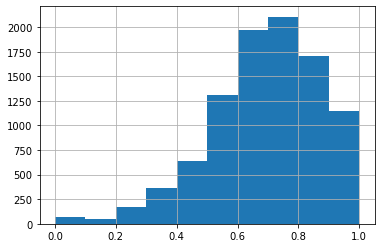

In [32]:
bundle_perform['answered_correctly'].hist()

In [33]:
part_perform = (train_upd_df
                  .pivot_table(index='part',
                              values='answered_correctly',
                              aggfunc=lambda x: x.sum()/len(x))
                 .sort_values(by='answered_correctly', ascending=False)
                 .reset_index())
display(part_perform)

,part,answered_correctly
0,1,0.733774
1,2,0.707265
2,3,0.692096
3,6,0.650695
4,7,0.645141
5,4,0.620959
6,5,0.606489


Возьмем описание частей с https://toeic-testpro.com/. Часть с нибольшими баллами _Photographs_. С наименьшими _Incomplete_sentences_ и _Short_talks_.

In [34]:
tags_perform = (train_upd_df
                  .pivot_table(index='tags',
                              values='answered_correctly',
                              aggfunc=lambda x: x.sum()/len(x))
                 .sort_values(by='answered_correctly', ascending=False)
                 .reset_index())
display(tags_perform)

,tags,answered_correctly
0,113 144 92,1.0
1,82 169 162 29,1.0
2,136 29,1.0
3,113 92 59,1.0
4,74 120 162 81,1.0
...,...,...
1496,74 92 59,0.0
1497,74 171 162 102,0.0
1498,161 169 92,0.0
1499,136 183 162 92,0.0


<AxesSubplot:>

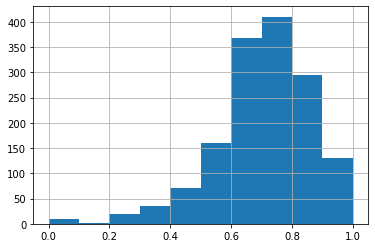

In [35]:
tags_perform['answered_correctly'].hist()

По тагам ситуация схожа с бандлами

#### Анализ по пользователям

Посмотрим на сколько коррелирует доля правильных ответов со временем затраченным перед вопросом


In [36]:
users_perform = (train_upd_df
                  .pivot_table(index='user_id',
                  values=['answered_correctly','prior_question_elapsed_time'],
                  aggfunc=[lambda x: x.sum()/len(x), 'mean']
                  )
                 #.sort_values(by='answered_correctly', ascending=False)
                 .reset_index())
display(users_perform)

user_id           <lambda>                              \
               answered_correctly prior_question_elapsed_time   
0          115           0.688889                19933.311111   
1          124           0.206897                18793.000000   
2         2746           0.611111                18055.555556   
3         5382           0.669355                36048.387097   
4         8623           0.638889                26107.407407   
...        ...                ...                         ...   
3817  20913319           0.632242                27666.629723   
3818  20913864           0.300000                18200.000000   
3819  20938253           0.609943                22630.590822   
3820  20948951           0.620000                19860.000000   
3821  20949024           0.297872                32757.021277   

                   mean                              
     answered_correctly prior_question_elapsed_time  
0              0.688889                19933.311111  
1              0.206897                18793.000000  
2              0.611111                18055.555556  
3              0.669355                36048.387097  
4              0.638889                26107.407407  
...                 ...                         ...  
3817           0.632242                27666.629723  
3818           0.300000                18200.000000  
3819           0.609943                22630.590822  
3820           0.620000                19860.000000  
3821           0.297872                32757.021277  

[3822 rows x 5 columns]

In [37]:
users_perform.xs(('<lambda>', 'answered_correctly'), axis=1)

0       0.688889
1       0.206897
2       0.611111
3       0.669355
4       0.638889
          ...   
3817    0.632242
3818    0.300000
3819    0.609943
3820    0.620000
3821    0.297872
Name: (<lambda>, answered_correctly), Length: 3822, dtype: float64

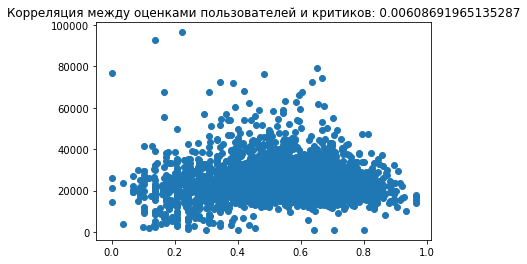

In [38]:
plt.scatter(users_perform['<lambda>']['answered_correctly'], users_perform['mean']['prior_question_elapsed_time'])
plt.title('Корреляция между оценками пользователей и критиков: ' + 
          str(users_perform['<lambda>']['answered_correctly'].corr(users_perform['mean']['prior_question_elapsed_time'])))
plt.show()

Корреляция между долей правильных ответов пользователей и временем перед ответом отсутствует

<AxesSubplot:xlabel='prior_question_had_explanation'>

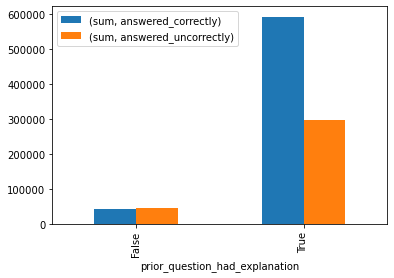

In [39]:
answers_with_explanation = (train_upd_df
                  .pivot_table(index='prior_question_had_explanation',
                              values='answered_correctly',
                              aggfunc=['sum', lambda x: ((-1)*(x-1)).sum()]
                              )
                )
answers_with_explanation.columns = [('sum', 'answered_correctly'), ('sum', 'answered_uncorrectly')]
answers_with_explanation.plot.bar()

In [40]:
answers_with_explanation

,"(sum, answered_correctly)","(sum, answered_uncorrectly)"
prior_question_had_explanation,,
False,42227.0,44163
True,592587.0,297300


Исходя из графика, если воспользовался пояснением, то вероятность ошибки в два раза ниже

#### Анализ по лекциям

In [41]:
train_lectures_upd_df = train_lectures_df.join(lectures_df.set_index('lecture_id')[['type_of', 'part', 'tag']], 
                                               on='content_id')
display(train_lectures_upd_df)

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,type_of,part,tag
89,653762,2746,6808,1,14,-1,-1,NaN,False,intention,2,129
117,10183847,5382,16736,1,21,-1,-1,NaN,False,concept,1,40
212,1424348597,5382,30207,1,104,-1,-1,NaN,False,concept,5,43
216,1425557777,5382,18545,1,121,-1,-1,NaN,False,concept,5,58
295,405813029,8623,10540,1,59,-1,-1,NaN,False,concept,1,99
...,...,...,...,...,...,...,...,...,...,...,...,...
999740,206141912,20938253,14443,1,286,-1,-1,NaN,False,concept,5,28
999746,206253699,20938253,21597,1,292,-1,-1,NaN,False,concept,5,116
999762,207265143,20938253,26404,1,308,-1,-1,NaN,False,solving question,5,52
999790,208152685,20938253,22362,1,336,-1,-1,NaN,False,concept,5,73


In [42]:
train_lectures_upd_df['type_of'].value_counts()

concept             14326
solving question     4468
intention            1113
Name: type_of, dtype: int64

In [43]:
train_lectures_part_df = (train_lectures_upd_df['part'].value_counts().
                          rename_axis('part').to_frame('counts').
                          join(part_perform.set_index('part')))
display(train_lectures_part_df)

,counts,answered_correctly
part,,
5,9371,0.606489
2,3819,0.707265
6,2488,0.650695
1,1553,0.733774
3,1002,0.692096
4,962,0.620959
7,712,0.645141


По самой проблемной части 5 больше всего лекций. Возможно выборка из первого млн строк не репрезентативна. В остальном логично: части 7 и 4 в меньшей степени были пройдены в лекциях

In [44]:
train_lectures_upd_df['tag'].value_counts()

62     601
27     553
136    420
163    400
26     393
      ... 
150      8
103      8
171      8
187      5
138      4
Name: tag, Length: 150, dtype: int64

### Выводы

1. В результате приведения типов данных удается сократить объем используемой памяти вдвое
2. `prior_question_elapsed_time` - можно перевести в целочисленный тип
3. В тестах возможно всего 4 варианта ответа
4. Вниз статистику по правильным ответам утягивают почти 25% наборов вопросов. Около 6% вообще не имеют правильных ответов
5. Часть с нибольшими баллами Photographs. С наименьшими Incomplete_sentences и Short_talks.
6. Корреляция между долей правильных ответов пользователей и временем перед ответом отсутствует
7. Если воспользовался пояснением, то вероятность ошибки в два раза ниже
8. По самой проблемной части 5 больше всего лекций. По другим проблемным частям 7 и 4 в меньшей степени были пройдены в лекциях